# Settings

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)


#library(lattice)
#library(timeSeries)


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [66]:
source("~/works/utils/r/myutils.r")
source("~/works/utils/r/myarimagarch.r")

## Data

In [3]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [4]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [5]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

In [6]:
# daily log. return
spx.ret <- diff(log(spx$a))

In [7]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [8]:
YEAR <- 252
hori <- 21
peri <- floor(hori/2)
#wind <- 5*YEAR
wind <- 7*YEAR

In [9]:
# testing
train_start <- '1991-01-01'
train_end <- '2000-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [10]:
n <- (nrow(train) - wind - hori)/floor(peri)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 74"


# Prophet

# ARIMA

In [35]:
cv.forecast <- function(x, h) {
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        #allowdrift=TRUE, allowmean = TRUE, # default
                        lambda="auto"), h=h)
}

In [36]:
result.m02 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12252.31
 ARIMA(0,0,0) with non-zero mean : -12248.37
 ARIMA(1,0,0) with non-zero mean : -12247.25
 ARIMA(0,0,1) with non-zero mean : -12246.81
 ARIMA(0,0,0) with zero mean     : 5005.842
 ARIMA(1,0,2) with non-zero mean : -12263.59
 ARIMA(0,0,2) with non-zero mean : -12245.56
 ARIMA(1,0,1) with non-zero mean : -12245.25
 ARIMA(1,0,3) with non-zero mean : -12261.66
 ARIMA(0,0,3) with non-zero mean : -12247.24
 ARIMA(2,0,1) with non-zero mean : -12251.02
 ARIMA(2,0,3) with non-zero mean : -12253.57
 ARIMA(1,0,2) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2) with non-zero mean : -12248.74

 Best model: ARIMA(1,0,2) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12263.54
 ARIMA(0,0,0) with non-zero mean : -12253.43
 ARIMA(1,0,0) with non-zero mean : -12253.68
 ARIMA(0,0

In [37]:
x <- result.m02
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


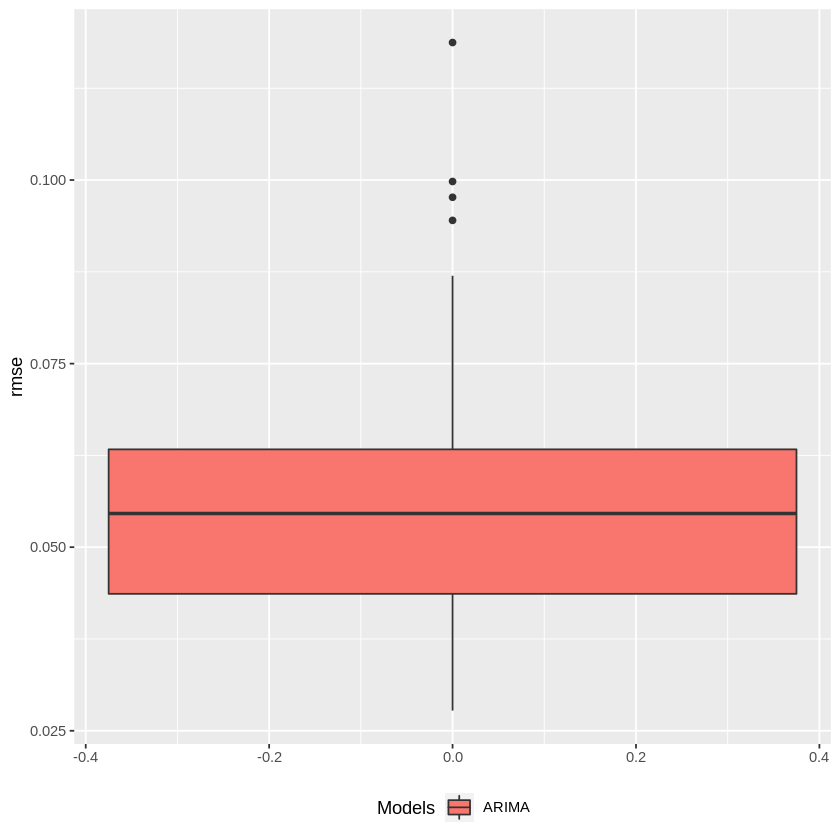

In [38]:
errors.m02 <- my.get_result(result.m02, 'ARIMA')
my.plot_errors(errors.m02, metrics=c('rmse'))

# Regression with ARIMA errors

In [49]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [50]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [51]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [52]:
colnames(trainx) <- c('logret','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)

                  logret      rsi    bbands        macd
1991-02-19  0.0008938101 72.59254 0.8419486 -0.03641515
1991-02-20 -0.0115721543 66.25313 0.7706927 -0.18551057
1991-02-21 -0.0004657216 66.00481 0.7330987 -0.30953562
1991-02-22  0.0018614141 66.54491 0.7402938 -0.39546732
1991-02-25  0.0043934960 67.84742 0.7305630 -0.43573971
1991-02-26 -0.0121907956 60.80133 0.6379610 -0.55105032

In [53]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    return(fc)
}

In [54]:
result.m03.1 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13090.73
 Regression with ARIMA(0,0,0) errors : -12481.33
 Regression with ARIMA(1,0,0) errors : -12481.38
 Regression with ARIMA(0,0,1) errors : -12480.83
 Regression with ARIMA(0,0,0) errors : -12381.52
 Regression with ARIMA(1,0,2) errors : -12482.89
 Regression with ARIMA(2,0,1) errors : -12481.71
 Regression with ARIMA(3,0,2) errors : -13113.99
 Regression with ARIMA(3,0,1) errors : Inf
 Regression with ARIMA(4,0,2) errors : -13085.22
 Regression with ARIMA(3,0,3) errors : -13121.87
 Regression with ARIMA(2,0,3) errors : Inf
 Regression with ARIMA(4,0,3) errors : -13113.33
 Regression with ARIMA(3,0,4) errors : -13121.99
 Regression with ARIMA(2,0,4) errors : -13095.36
 Regression with ARIMA(4,0,4) errors : -13124.65
 Regression with ARIMA(5,0,4) errors : -13115.73
 Regression with ARIMA(4,0,5) errors : -13124.6
 Regression with ARIMA(3,0,5) errors : -13123.9
 Regression with ARIMA

In [55]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Normalize data

In [56]:
mins <- t(apply(trainx, 2, min))
maxs <- t(apply(trainx, 2, max))
print(data.frame(rbind(mins, maxs), row.names=c('min','max')))

         logret      rsi     bbands      macd
min -0.07112747 18.08944 -0.3975811 -1.162421
max  0.04988692 84.90071  1.3157451  1.147627


In [57]:
cv.forecast.norm <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    x <- my.minmaxscale(x)
    sc <- attr(x, 'scaled:center')
    ss <- attr(x, 'scaled:scale')
    
    if (!is.null(xreg)) {
        xreg <- my.minmaxscale(xreg)
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    fc.m <- my.minmaxscale(fc$mean, sc, ss)
    fc <- list(method=fc$method, mean=fc.m)
    return(fc)
}

In [58]:
result.m03.2 <- my.tsCV(trainx[,1], cv.forecast.norm, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -3194.691
 Regression with ARIMA(0,0,0) errors : -2585.311
 Regression with ARIMA(1,0,0) errors : -2585.367
 Regression with ARIMA(0,0,1) errors : -2584.812
 Regression with ARIMA(0,0,0) errors : -2587.322
 Regression with ARIMA(1,0,2) errors : -2586.88
 Regression with ARIMA(2,0,1) errors : -2585.699
 Regression with ARIMA(3,0,2) errors : -3217.866
 Regression with ARIMA(3,0,1) errors : -2582.431
 Regression with ARIMA(4,0,2) errors : -3189.202
 Regression with ARIMA(3,0,3) errors : -3228.402
 Regression with ARIMA(2,0,3) errors : -3195.144
 Regression with ARIMA(4,0,3) errors : -3221.289
 Regression with ARIMA(3,0,4) errors : -3227.064
 Regression with ARIMA(2,0,4) errors : -3199.34
 Regression with ARIMA(4,0,4) errors : -3228.633
 Regression with ARIMA(5,0,4) errors : -3219.718
 Regression with ARIMA(4,0,5) errors : -3228.581
 Regression with ARIMA(3,0,5) errors : -3227.553
 Regressio

In [59]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [60]:
result.m03.3 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13090.73
 Regression with ARIMA(0,0,0) errors : -12481.33
 Regression with ARIMA(1,0,0) errors : -12481.38
 Regression with ARIMA(0,0,1) errors : -12480.83
 Regression with ARIMA(0,0,0) errors : -12381.52
 Regression with ARIMA(1,0,2) errors : -12482.89
 Regression with ARIMA(2,0,1) errors : -12481.71
 Regression with ARIMA(3,0,2) errors : -13113.99
 Regression with ARIMA(3,0,1) errors : Inf
 Regression with ARIMA(4,0,2) errors : -13085.22
 Regression with ARIMA(3,0,3) errors : -13121.87
 Regression with ARIMA(2,0,3) errors : Inf
 Regression with ARIMA(4,0,3) errors : -13113.33
 Regression with ARIMA(3,0,4) errors : -13121.99
 Regression with ARIMA(2,0,4) errors : -13095.36
 Regression with ARIMA(4,0,4) errors : -13124.65
 Regression with ARIMA(5,0,4) errors : -13115.73
 Regression with ARIMA(4,0,5) errors : -13124.6
 Regression with ARIMA(3,0,5) errors : -13123.9
 Regression with ARIMA

In [61]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Compare Errors

In [69]:
my.figsize(10,6)

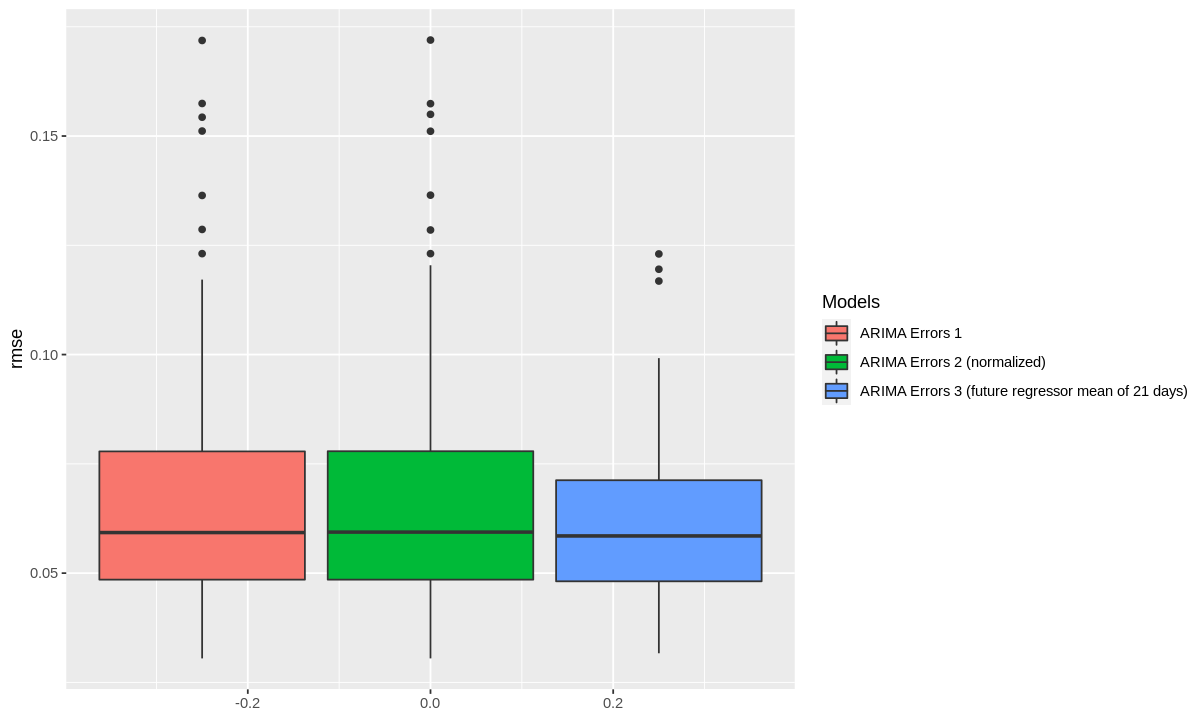

In [70]:
errors.m03.1 <- my.get_result(result.m03.1, 'ARIMA Errors 1')
errors.m03.2 <- my.get_result(result.m03.2, 'ARIMA Errors 2 (normalized)')
n <- paste('ARIMA Errors 3 (future regressor mean of', hori ,'days)', sep=' ')
errors.m03.3 <- my.get_result(result.m03.3, n)

x <- rbind(errors.m03.1, errors.m03.2)
x <- rbind(x, errors.m03.3)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [71]:
result.m03 <- result.m03.3
#errors.m03 <- errors.m03.3

# ARIMA+GARCH

In [73]:
cv.forecast <- function(x, h) {
    forc <- ag2.forecast(x, h, out.sample=0)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1])
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

In [ ]:
my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4])

In [75]:
result.m04 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

[1] "11 % done."
[1] "21 % done."
[1] "32 % done."
[1] "42 % done."
[1] "GARCH model does not converge"
[1] "53 % done."
[1] "63 % done."
[1] "74 % done."
[1] "84 % done."
[1] "95 % done."


In [77]:
x <- result.m04
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


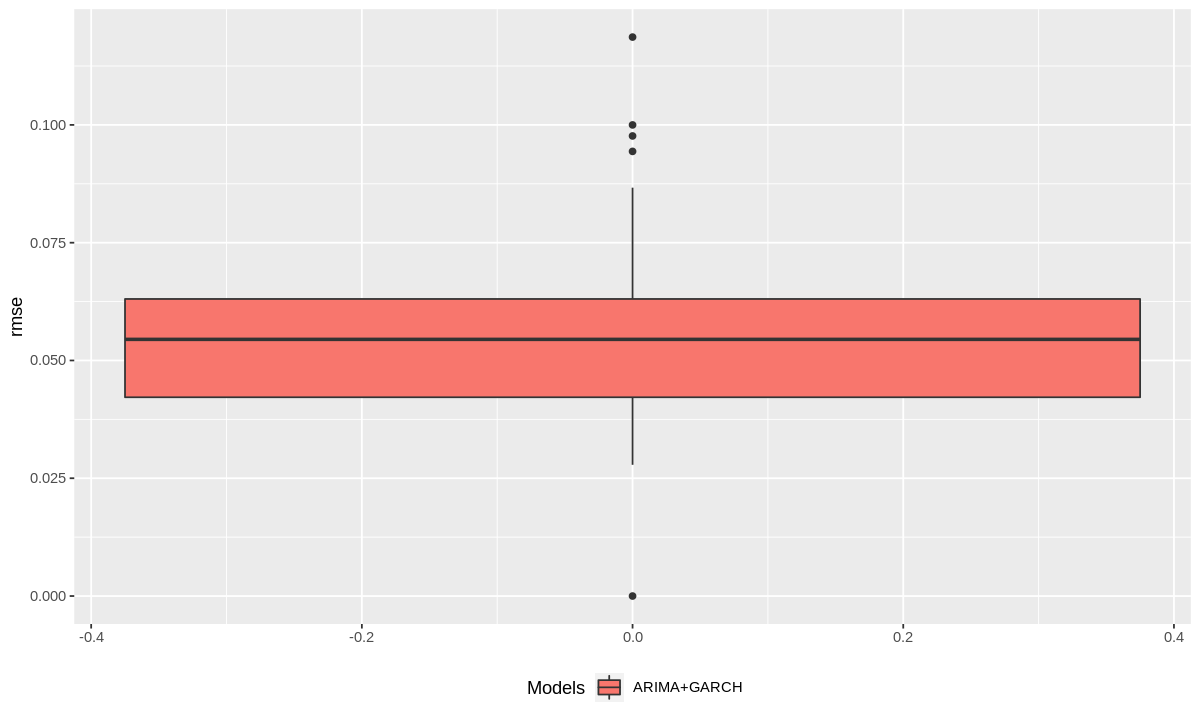

In [78]:
errors.m04 <- my.get_result(result.m04, 'ARIMA+GARCH')
my.plot_errors(errors.m04, metrics=c('rmse'))

# Gradient Boosting

# Model Comparision